In [45]:
from dask.distributed import Client
import dask.dataframe as dd
import pandas as pd

In [41]:
client = Client()
client

/mnt/abnorm/venv/lib/python3.10/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37905 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:37905/status,
Dashboard: http://127.0.0.1:37905/status,Workers: 6
Total threads: 18,Total memory: 49.01 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:32923,Workers: 0
Dashboard: http://127.0.0.1:37905/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:43977,Total threads: 3
Dashboard: http://127.0.0.1:42757/status,Memory: 8.17 GiB
Nanny: tcp://127.0.0.1:41779,


2025-11-14 17:05:09,862 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ca9cc8a9722e3ab99c1b676b130013aa initialized by task ('shuffle-transfer-ca9cc8a9722e3ab99c1b676b130013aa', 2) executed on worker tcp://127.0.0.1:43061
2025-11-14 17:05:22,463 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ca9cc8a9722e3ab99c1b676b130013aa deactivated due to stimulus 'task-finished-1763139922.461331'
2025-11-14 17:05:22,463 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle ca9cc8a9722e3ab99c1b676b130013aa deactivated due to stimulus 'task-finished-1763139922.461331'
2025-11-14 17:05:33,490 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 364b09ea16c19f08a6dce97eaabfa254 initialized by task ('shuffle-transfer-364b09ea16c19f08a6dce97eaabfa254', 16) executed on worker tcp://127.0.0.1:43977
2025-11-14 17:05:33,490 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 364b09ea16c19f08a6dce97eaabfa254 initialized by task ('shuffle-transfer-364b09ea16c19f0

In [42]:
df = dd.read_csv("/data/*.csv", blocksize="256MB")
df.head()

,when,hwid,metric,value
0,1601510485159,SW-065,SA4,0
1,1601510485159,SW-065,SA3,0
2,1601510485159,SW-065,SA2,0
3,1601510485159,SW-065,S34,0
4,1601510485159,SW-065,S33,1


In [3]:
df["when"].min().compute(), df["when"].max().compute()

(np.int64(1601510422405), np.int64(1617235197606))

In [43]:
# Convert UNIX milliseconds → datetime
df["timestamp"] = dd.to_datetime(df["when"], unit="ms", errors="coerce")
df = df.dropna(subset=["timestamp"])

#  Filter to Jan–Mar 2021
df = df[(df["timestamp"] >= "2021-01-01") & (df["timestamp"] <= "2021-03-31")]

#  Set index & repartition by day
df = df.set_index("timestamp")
df = df.repartition(freq="1D")

df.head()

,when,hwid,metric,value
timestamp,,,,
2021-01-01 00:00:01.846,1.609459e+12,SW-088,SA11,0.0
2021-01-01 00:00:01.846,1.609459e+12,SW-088,S72,60.0
2021-01-01 00:00:01.846,1.609459e+12,SW-088,S71,60.0
2021-01-01 00:00:01.846,1.609459e+12,SW-088,SA9,0.0
2021-01-01 00:00:01.846,1.609459e+12,SW-088,SA12,0.0


In [44]:
engine_metrics = ["S117", "S118", "S169", "S170"]

df_eng = df[df["metric"].isin(engine_metrics)]
df_eng.head()

,when,hwid,metric,value
timestamp,,,,
2021-01-01 00:00:01.846,1.609459e+12,SW-088,S118,0.0
2021-01-01 00:00:01.846,1.609459e+12,SW-088,S117,0.0
2021-01-01 00:00:04.289,1.609459e+12,SW-088,S170,0.0
2021-01-01 00:00:04.289,1.609459e+12,SW-088,S169,0.0
2021-01-01 00:00:28.352,1.609459e+12,SW-065,S118,0.0


In [7]:
df_eng["value"].describe().compute()

count    1.965996e+06
mean     2.078056e-01
std      4.057370e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: value, dtype: float64

In [46]:
def resample_partition(pdf):
    out = (
        pdf
        .groupby(["hwid", "metric"])
        .resample("1min")["value"]
        .last()
        .reset_index()
    )
    return out

df_eng = df_eng.map_partitions(lambda pdf: pdf.sort_index())
df_eng_resampled = df_eng.map_partitions(resample_partition, meta={
    "hwid": "u8",
    "metric": "u8",
    "timestamp": "datetime64[ns]",
    "value": "int8",
})
df_eng_resampled.head()

,hwid,metric,timestamp,value
0,SW-065,S117,2021-01-01 00:00:00,0.0
1,SW-065,S117,2021-01-01 00:01:00,0.0
2,SW-065,S117,2021-01-01 00:02:00,0.0
3,SW-065,S117,2021-01-01 00:03:00,0.0
4,SW-065,S117,2021-01-01 00:04:00,0.0


In [47]:
metric_names = (
    df_eng_resampled["metric"].drop_duplicates().compute().tolist()
)
metric_names = sorted(metric_names)

meta_wide = pd.DataFrame(
    {
        "timestamp": pd.Series([], dtype="datetime64[ns]"),
        "hwid": pd.Series([], dtype="object"),
    }
)
for col in metric_names:
    meta_wide[col] = pd.Series([], dtype="float32")


def to_wide(pdf: pd.DataFrame) -> pd.DataFrame:
    if pdf.empty:
        return meta_wide.head(0)

    pdf = pdf.sort_values(["hwid", "timestamp"])
    wide = (
        pdf
        .pivot_table(
            index=["timestamp", "hwid"],
            columns="metric",
            values="value",
            aggfunc="last",
        )
        .reindex(columns=metric_names, fill_value=0)
        .reset_index()
    )

    wide = wide.astype(meta_wide.dtypes.to_dict())
    return wide


df_eng_wide = df_eng_resampled.map_partitions(to_wide, meta=meta_wide)

df_eng_wide = df_eng_wide.persist()
df_eng_wide.head()

metric,timestamp,hwid,S117,S118,S169,S170
0,2021-01-01 00:00:00,SW-065,0.0,0.0,0.0,0.0
1,2021-01-01 00:00:00,SW-088,0.0,0.0,0.0,0.0
2,2021-01-01 00:00:00,SW-115,0.0,0.0,0.0,0.0
3,2021-01-01 00:01:00,SW-065,0.0,0.0,0.0,0.0
4,2021-01-01 00:01:00,SW-088,0.0,0.0,0.0,0.0


In [48]:
engine_cols = [c for c in engine_metrics if c in df_eng_wide.columns]

trans_meta = df_eng_wide._meta.copy()
for col in engine_cols:
    trans_meta[col + "_transitions"] = pd.Series([], dtype="float32")


def compute_engine_transitions(df_part: pd.DataFrame) -> pd.DataFrame:
    if df_part.empty:
        return trans_meta.head(0)

    df_part = df_part.sort_values(["hwid", "timestamp"])
    for col in engine_cols:
        diff = (
            df_part.groupby("hwid")[col]
            .diff()
            .abs()
            .fillna(0)
        )
        df_part[col + "_transitions"] = diff.astype("float32")

    return df_part


df_eng_with_trans = df_eng_wide.map_partitions(
    compute_engine_transitions,
    meta=trans_meta,
)

df_eng_with_trans.head()

metric,timestamp,hwid,S117,S118,S169,S170,S117_transitions,S118_transitions,S169_transitions,S170_transitions
0,2021-01-01 00:00:00,SW-065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2021-01-01 00:01:00,SW-065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2021-01-01 00:02:00,SW-065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2021-01-01 00:03:00,SW-065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,2021-01-01 00:04:00,SW-065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
value_cols = engine_cols 
transition_cols = [c + "_transitions" for c in engine_cols]
column_order = ["hwid", "timestamp"] + value_cols + transition_cols

agg_meta = pd.DataFrame({
    "hwid": pd.Series([], dtype=df_eng_with_trans._meta["hwid"].dtype),
    "timestamp": pd.Series([], dtype="datetime64[ns]")
})
for col in value_cols + transition_cols:
    agg_meta[col] = pd.Series([], dtype=df_eng_with_trans._meta[col].dtype)
agg_meta = agg_meta[column_order]


def per_hour_aggregation(df_part: pd.DataFrame) -> pd.DataFrame:
    if df_part.empty:
        return agg_meta.head(0)

    df_part = df_part.sort_values(["hwid", "timestamp"])
    df_part = df_part.set_index("timestamp")

    agg_dict = {col: "mean" for col in engine_cols}
    agg_dict.update({col + "_transitions": "sum" for col in engine_cols})

    hourly = (
        df_part
        .groupby("hwid")
        .resample("1H")
        .agg(agg_dict)
        .reset_index()
    )

    hourly = hourly[column_order]
    hourly = hourly.astype(agg_meta.dtypes.to_dict())
    return hourly


df_eng_hourly = df_eng_with_trans.map_partitions(
    per_hour_aggregation,
    meta=agg_meta,
)

df_eng_hourly = df_eng_hourly.persist()
df_eng_hourly.head()

metric,hwid,timestamp,S117,S118,S169,S170,S117_transitions,S118_transitions,S169_transitions,S170_transitions
0,SW-065,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,SW-065,2021-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,SW-065,2021-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,SW-065,2021-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,SW-065,2021-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
TRANSITION_THRESHOLD = 5

def flag_anomalies(df_part):
    for col in engine_cols:
        t_col = col + "_transitions"
        if t_col in df_part:
            df_part[col + "_anomaly"] = df_part[t_col] > TRANSITION_THRESHOLD
    
    # Any engine anomalous → device-hour anomalous
    anomaly_cols = [c + "_anomaly" for c in engine_cols if c + "_anomaly" in df_part]
    df_part["any_engine_anomaly"] = False
    if anomaly_cols:
        df_part["any_engine_anomaly"] = df_part[anomaly_cols].any(axis=1)
    
    return df_part

df_eng_hourly_anom = df_eng_hourly.map_partitions(flag_anomalies)
df_eng_hourly_anom = df_eng_hourly_anom.persist()

df_eng_hourly_anom.head()

metric,hwid,timestamp,S117,S118,S169,S170,S117_transitions,S118_transitions,S169_transitions,S170_transitions,S117_anomaly,S118_anomaly,S169_anomaly,S170_anomaly,any_engine_anomaly
0,SW-065,2021-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False
1,SW-065,2021-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False
2,SW-065,2021-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False
3,SW-065,2021-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False
4,SW-065,2021-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,False,False,False,False,False


In [51]:
device_id = "SW-115"

anom_device = df_eng_hourly_anom[
    (df_eng_hourly_anom["hwid"] == device_id) &
    (df_eng_hourly_anom["any_engine_anomaly"])
]

anom_device.compute().head()


metric,hwid,timestamp,S117,S118,S169,S170,S117_transitions,S118_transitions,S169_transitions,S170_transitions,S117_anomaly,S118_anomaly,S169_anomaly,S170_anomaly,any_engine_anomaly
71,SW-115,2021-01-04 23:00:00,0.711538,0.711538,0.764706,0.862745,1.0,1.0,6.0,2.0,False,False,True,False,True
54,SW-115,2021-01-05 06:00:00,0.964912,1.000000,0.839286,0.892857,2.0,0.0,6.0,1.0,False,False,True,False,True
59,SW-115,2021-01-05 11:00:00,0.418182,0.490909,0.074074,0.351852,6.0,5.0,5.0,7.0,True,False,False,True,True
60,SW-115,2021-01-05 12:00:00,0.283019,0.339623,0.411765,0.176471,4.0,7.0,3.0,3.0,False,True,False,False,True
61,SW-115,2021-01-06 13:00:00,0.145455,0.690909,0.283019,0.641509,1.0,1.0,6.0,2.0,False,False,True,False,True


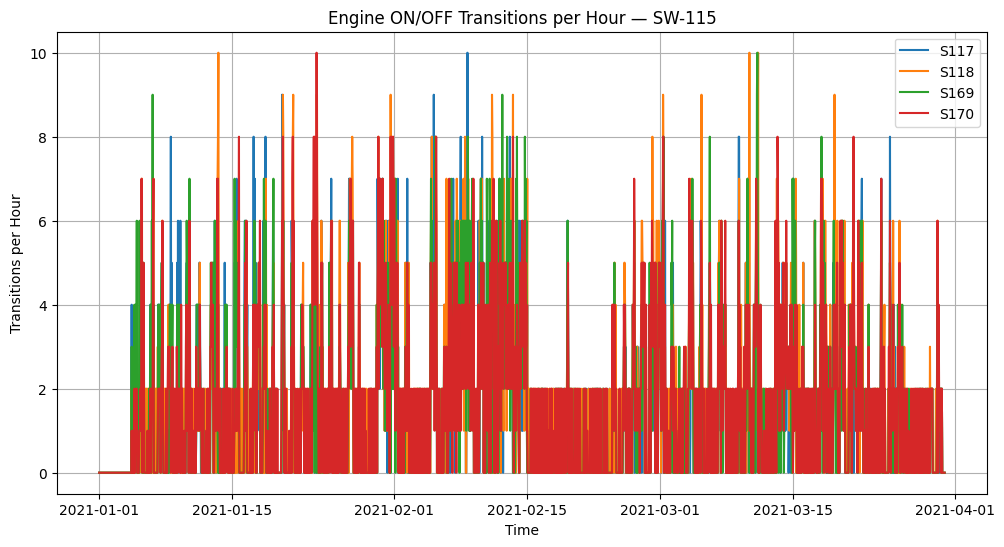

In [ ]:
import matplotlib.pyplot as plt

device_id = "SW-115"
df_plot = df_eng_hourly_anom[df_eng_hourly_anom["hwid"] == device_id].compute()

engine_cols = ["S117", "S118", "S169", "S170"]

plt.figure(figsize=(12,6))
for col in engine_cols:
    transitions = col + "_transitions"
    if transitions in df_plot:
        plt.plot(df_plot["timestamp"], df_plot[transitions], label=col)

plt.xlabel("Time")
plt.ylabel("Transitions per Hour")
plt.title(f"Engine ON/OFF Transitions per Hour — {device_id}")
plt.legend()
plt.grid()
plt.show()


### Engine Transitions Per Hour

In [53]:
device_ids = df_eng_hourly_anom["hwid"].unique().compute().tolist()
device_ids

['SW-115', 'SW-065', 'SW-088', 'SW-106']

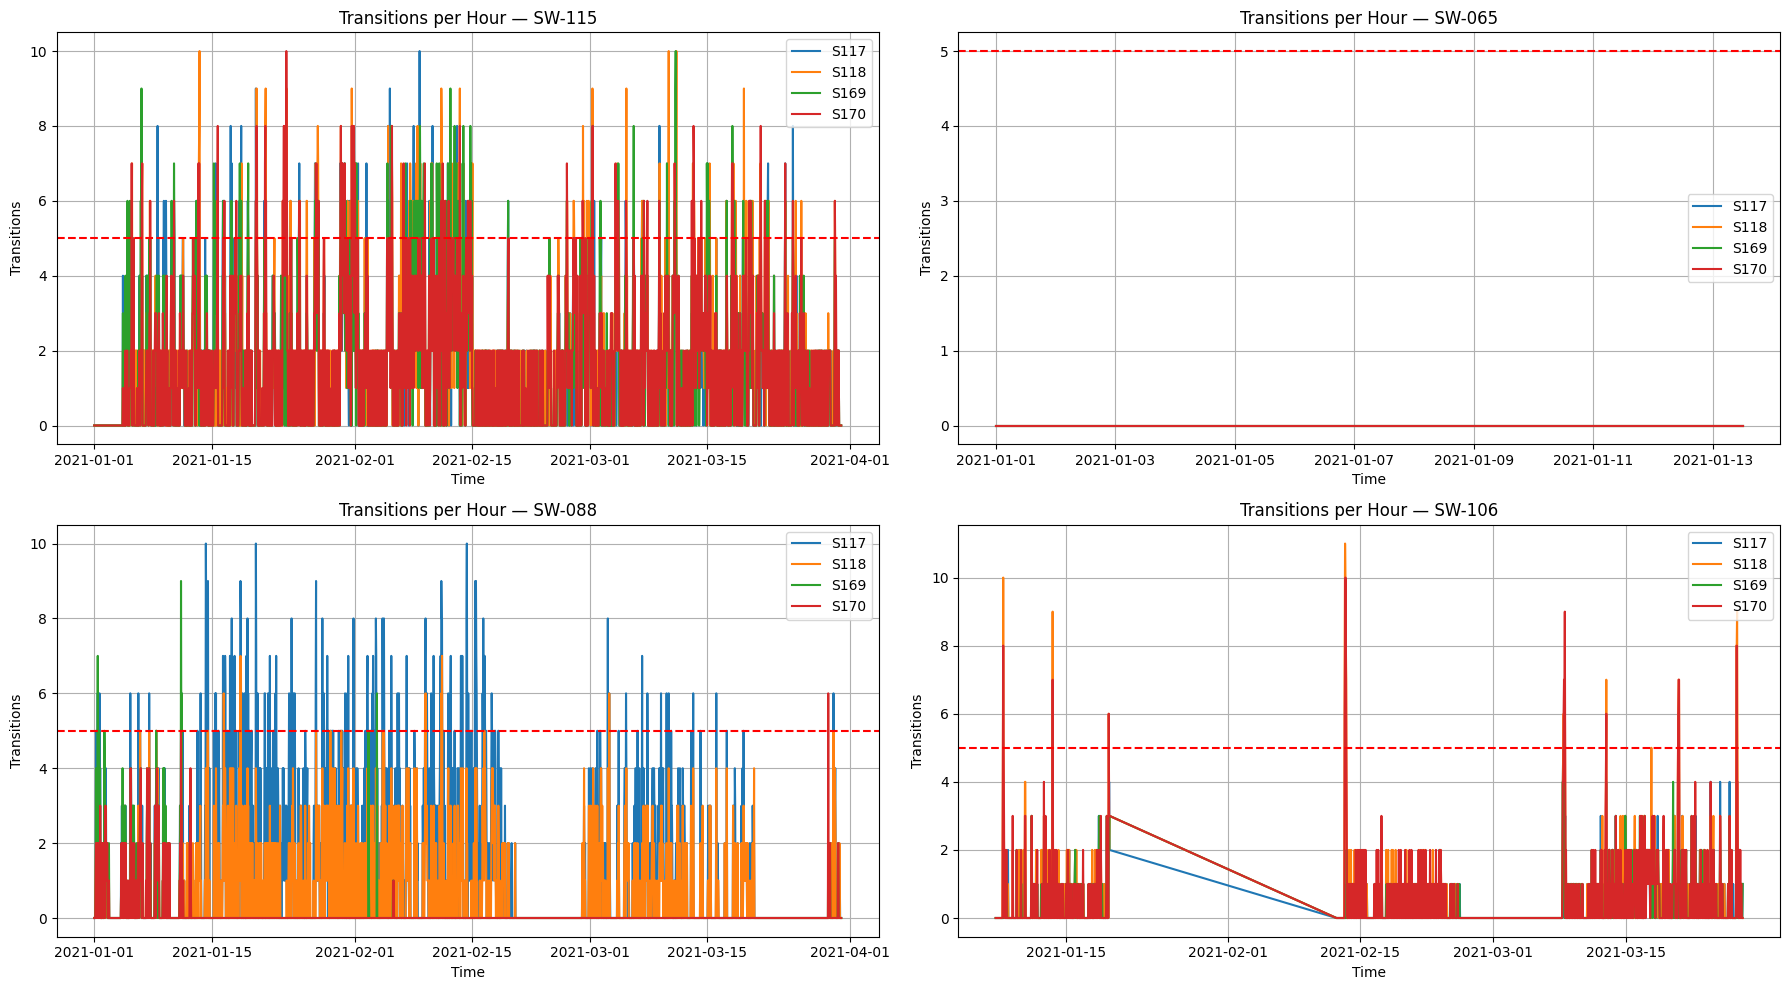

In [ ]:
import os

save_dir = "./fig"

n_devices = len(device_ids)
rows = 2
cols = 2

fig, axes = plt.subplots(rows, cols, figsize=(18, 10))
axes = axes.flatten()

for i, device_id in enumerate(device_ids):
    ax = axes[i]

    df_plot = (
        df_eng_hourly_anom[df_eng_hourly_anom["hwid"] == device_id]
        .compute()
        .sort_values("timestamp")
    )
    if df_plot.empty:
        continue


    for col in engine_cols:
        t_col = col + "_transitions"
        if t_col in df_plot:
            ax.plot(df_plot["timestamp"], df_plot[t_col], label=col)


    ax.axhline(TRANSITION_THRESHOLD, color="red", linestyle="--")

    ax.set_title(f"Transitions per Hour — {device_id}")
    ax.set_ylabel("Transitions")
    ax.set_xlabel("Time")
    ax.grid(True)
    ax.legend()


for j in range(i+1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()


png_path = os.path.join(save_dir, "transitions_grid.png")
pdf_path = os.path.join(save_dir, "transitions_grid.pdf")

fig.savefig(png_path, dpi=200)
fig.savefig(pdf_path)

plt.show()


### Any Engine Anomaly

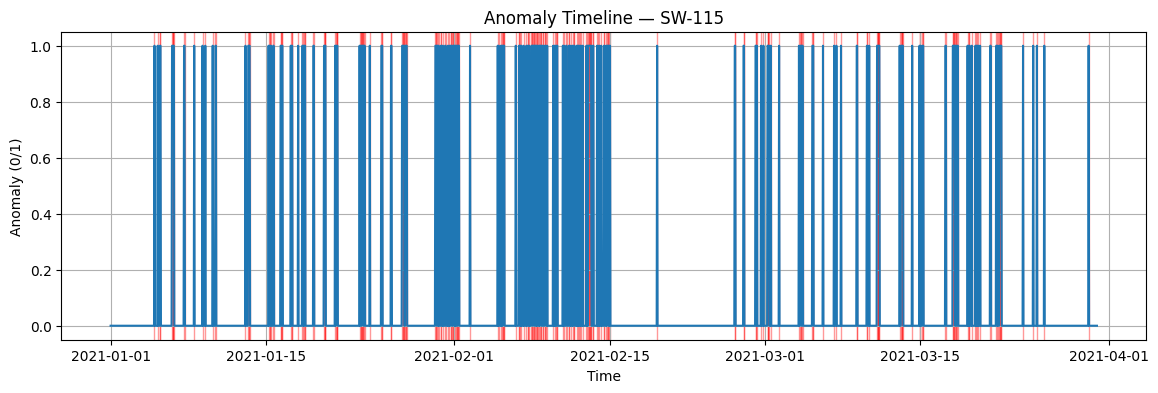

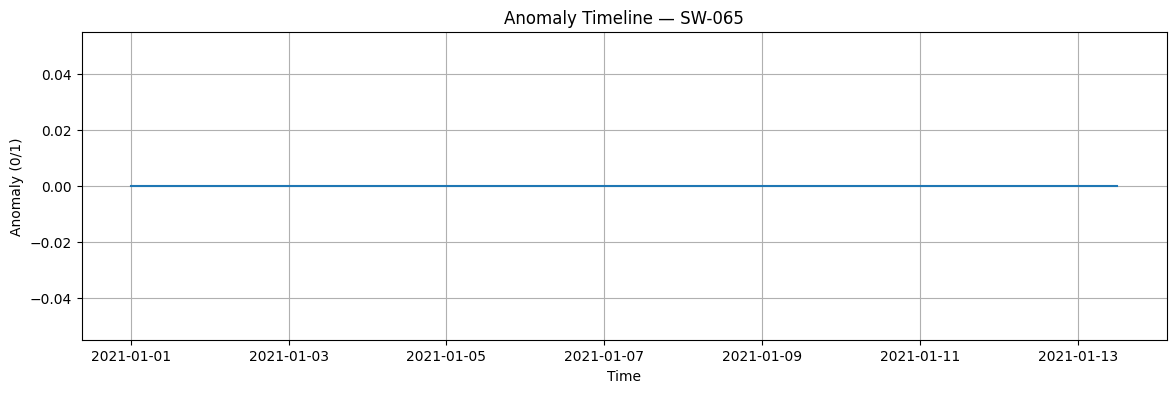

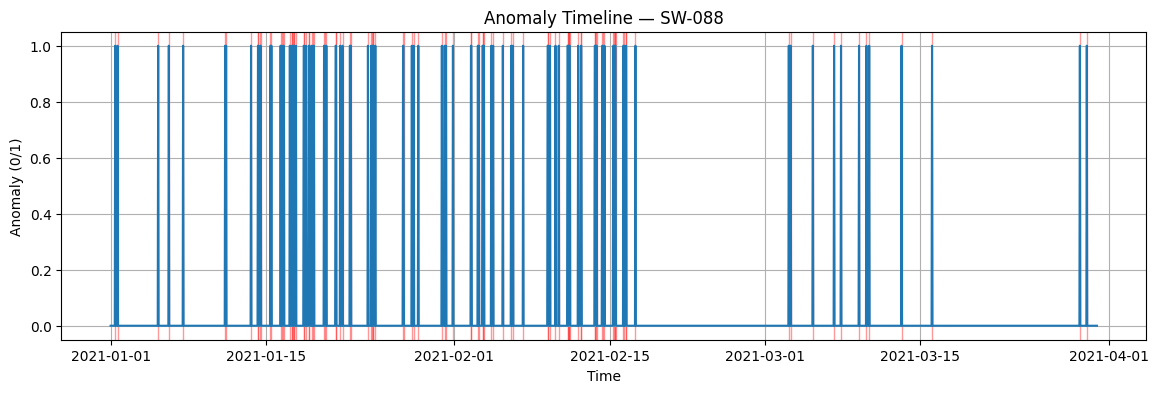

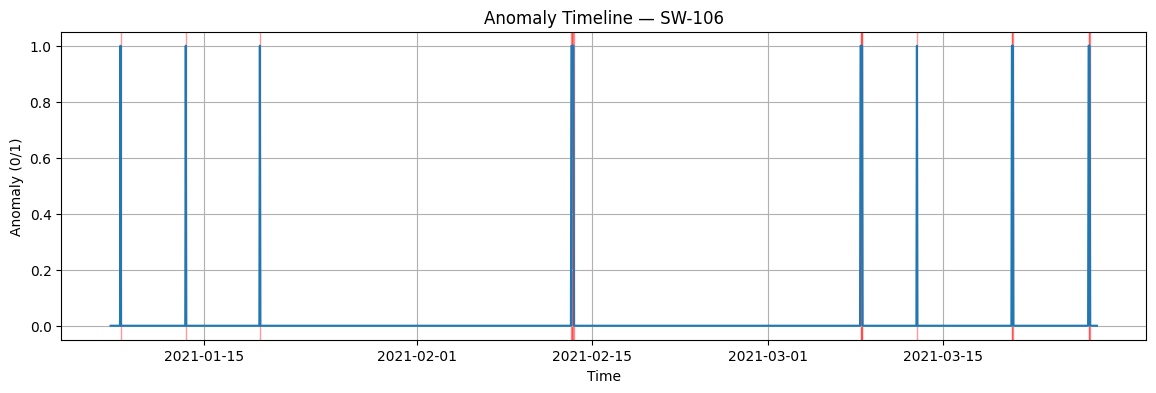

In [55]:
for device_id in device_ids:
    df_plot = df_eng_hourly_anom[df_eng_hourly_anom["hwid"] == device_id].compute()
    df_plot = df_plot.sort_values("timestamp")

    if df_plot.empty:
        continue

    plt.figure(figsize=(14,4))
    plt.plot(df_plot["timestamp"], df_plot["any_engine_anomaly"].astype(int), label="Anomaly Flag")

    for idx, row in df_plot.iterrows():
        if row["any_engine_anomaly"]:
            plt.axvspan(row["timestamp"], row["timestamp"], color="red", alpha=0.4)

    plt.title(f"Anomaly Timeline — {device_id}")
    plt.xlabel("Time")
    plt.ylabel("Anomaly (0/1)")
    plt.grid()

    png_path = os.path.join(save_dir, f"anomaly_timeline_{device_id}.png")
    pdf_path = os.path.join(save_dir, f"anomaly_timeline_{device_id}.pdf")

    plt.savefig(png_path, dpi=200)
    plt.savefig(pdf_path)

    plt.show()